# Suy luận Bayes sử dụng Tensorflow probability


## Ôn lại về phương pháp Bayes

Một cách tổng quát, suy diễn Bayes dựa trên định lý Bayes như sau :

$p(\theta |y,x)\propto p(y|\theta ,x) p(\theta ,x)$

theo đó, phân phối hậu định của một tham số Theta (khi ta có trong tay dữ liệu biến kết quả Y và hằng số X là một matrix các predictors trong mô hình) tỉ lệ với tích của hàm likelihood (xác suất có điều kiện của y khi có theta và x) và phân phối tiền định (prior= giả thuyết về phân phối của theta).

Như thường lệ, suy luận thống kê theo trường phái Bayes được thực hiện qua một mô hình xác suất. Gọi là mô hình xác suất vì tất cả bộ phận bên trong mô hình đều được xây dựng như tham số của các quy luật phân phối xác suất, kết quả đầu ra của mô hình là 1 hàm likelihood của 1 phân phối nào đó, mỗi tham số bên trong phân phối kết quả này lại được xác định bằng những họ phân phối khác. Mô hình Bayes giống như một cuộc giải phẫu mà bạn bóc tách từng cơ phận của phân phối kết quả, bạn phải đưa ra giả định ban đầu (giả thuyết tiền định, prior) đến từng chi tiết nhỏ nhất. 

Sau đó, bạn sẽ dùng một alorithm Markov Chain MonteCarlo (MCMC) để lấy mẫu phân phối hậu nghiệm của các tham số trong mô hình dựa vào kết quả quan sát thực tế của biến kết quả. Từ quy trình này, ta có Phân phối hậu nghiệm chứa trong các chuỗi MCMC cho phép suy luận thống kê.

Trong bài toán so sánh đại lượng Y giữa các phân nhóm, mô hình của chúng ta sẽ gồm những yếu tố sau đây :

Một đại lượng Y là biến liên tục mà ta muốn khảo sát, ta gọi nó là biến kết quả (outcome). Giá trị outcome Y này được mô tả bằng một kiểu phân phối xác định.

Theo tinh thần của t test của Gosset, outcome là giá trị trung bình của biến Y, và khác biệt trung bình giữa 2 phân nhóm X1 và X2. Khác biệt trung bình này được mô tả bằng 1 phân phối t. Như ta biết, phân phối t có 3 tham số là mu (location), sigma (scale) và kiểu hình (hay độ tự do) Nu.

Mục tiêu của t test Bayes là tìm phân phối hậu định của 3 tham số này.

## Mô hình Bayes dùng TFP

Khi áp dụng TFP, có 2 bước cần làm như sau:

### 1) Thiết kế mô hình, sử dụng method JointDistribution:

Đầu tiên, cần giả định về phân phối của kết quả (hàm likelihood), trong trường hợp này là Student t:

tfd.Independent(tfd.StudentT(df = $\nu$, loc = $\mu$, scale = $\sigma$), reinterpreted_batch_ndims=1)

Phân phối Student-t có 3 tham số: độ tự do (df) = $\nu$ (nu), vị trí trung tâm (location) = $\mu$ (mu), và độ phân tán (scale) = $\sigma$ (sigma)

Giá trị trung bình của kết quả được xác định chủ yếu bởi $\mu$, 

Cho bài toán so sánh 2 phân nhóm độc lập X1, X2, ta giả định $\mu = b_1 . X1 + b_2 . X2$, với X1 và X2 là 2 vector sinh ra bởi one-hot encoding (giá trị 0/1) trong design matrix.

2 tham số $b_1$ và  $b_2$ được giả định có phân phối Gaussian (Normal): $b_i \sim \text{Normal}(\mu_i, \sigma_i)$ ; Ta có thể dùng 1 prior rỗng cho $\mu_i, \sigma_i$, thí dụ =0; tuy nhiên tốt hơn cả, là dùng trung bình và sd của 2 phân nhóm trong thí nghiệm, hay từ y văn... như prior, mô hình sẽ hội tụ nhanh chóng và chính xác hơn.

Với $\nu$, ta không có thông tin nào cả, nên sẽ dùng 1 prior rỗng, nhưng hợp lý, thí dụ $\nu \sim Exponential(rate = 1)$

Với $\sigma$, ta có thể dùng prior rỗng, thí dụ $\sigma \sim Cauchy(loc = 0, scale = 5)$, hoặc dùng 1 prior có ý nghĩa từ y văn hay thực nghiệm

Lưu ý: Khi compile mô hình, X1 và X2 cần được chuyển từ numpy array sang tensor, tất cả scalar, vector và prior đều phải cùng loại dữ liệu (thí dụ float32, float64), nếu không tensorflow không chạy và báo lỗi.

### 2) Viết hàm để lấy mẫu chuỗi MCMC

Công đoạn này tương đối khó, vì phải làm thủ công mọi thứ, nhưng một khi có code trong tay thì bạn cứ thi hành mà không cần quá bận tâm về cơ chế bên trong.

Để lấy mẫu MCMC ta cần 1 hàm run_hmc_chain() gồm các arguments như: init_state (trạng thái ban đầu), bijectors (hoán chuyển kết quả posterior), 1 hàm tính log_prob, các tham số kỹ thuật: step_size, num_leapfrog_steps, num_samples=số lượt lấy mẫu, burnin = số mẫu thực sự được ghi lại.

Hàm này sử dụng method tfp.mcmc.sample_chain và 3 kernels: 

+ hmc_kernel sử dụng method tfp.mcmc.HamiltonianMonteCarlo với argument là hàm tính log_prob, num_leapfrog_steps, step_size 

+ tfp.mcmc.TransformedTransitionKernel dùng bijectors để hoán chuyển kết quả hmc_kernel

+ tfp.mcmc.SimpleStepSizeAdaptation nhằm tối ưu kết quả từ 2 kernel bên trên

Lưu ý, hàm run_hmc_chain được tạo ra bằng decorator @tf.function() để có 1 tensorflow graph

Đó là phần lõi, còn giao thức là hàm sample_posterior với các arguments: object mô hình JointDistribution, list parameters (tham số trong mô hình) cần lấy mẫu, init_state  = trạng thái ban đầu, được tạo ra bằng cách sample 1 lần từ object mô hình JointDistribution, danh sách bijectors tương ứng với list params, các tham số kỹ thuật: step_size, num_chains=số chuỗi MCMC cho mỗi parameter, num_samples=số lượt lấy mẫu, burnin=kích thước thực tế được ghi lại cho mỗi chuỗi.

Lưu ý: Bên trong hàm này, ngoài việc dùng bijectors để hoán chuyển tùy ý kết quả posterior của từng tham số, ta có thể tính thêm posterior mới từ những posterior đã có, thí dụ cho bài toán Student-t test so sánh 2 phân nhóm, ta có thể tính posterior cho khác biệt trung bình 2 phân nhóm bằng dòng code:

posterior['Difference'] = posterior[params[1]] - posterior[params[0]]

Tương tự, ta có thể viết 1 vòng lặp để tính posterior nhằm so sánh bắt cặp tuần tự trong post-hoc test của bài toán ANOVA đơn biến...


### 3) Suy diễn thống kê

Việc suy diễn dựa trên phân phối hậu nghiệm (posterior) - chuỗi MCMC, dùng thư viện arviz

In [1]:
# thư viện

import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

from patsy import dmatrices  # Tạo design matrix
import numpy as np
import pandas as pd

# TF và TFP
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors
Root = tfd.JointDistributionCoroutine.Root

dtype = tf.float32 # Dùng float32 cho toàn bộ tensor

Phiên bản các thư viện:

Ghi chú: Nhi sử dụng TFP local trên máy tính, dùng TF-GPU 2.0 và TFP 0.8; 
Nếu không có GPU thì code vẫn chạy, nhưng chậm hơn

bạn có thể chạy trên Google colab nhưng phần code có thể khác.

In [2]:
from sinfo import sinfo
sinfo()

if tf.test.gpu_device_name() != '/device:GPU:0':
    print('WARNING: GPU device not found.')
else:
    print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

-----
arviz                       0.7.0
matplotlib                  3.2.1
numpy                       1.18.3
pandas                      1.0.3
patsy                       0.5.1
seaborn                     0.10.0
sinfo                       0.3.1
tensorflow                  2.0.0
tensorflow_probability      0.8.0
-----
IPython             7.12.0
jupyter_client      5.3.4
jupyter_core        4.6.1
jupyterlab          1.2.6
notebook            6.0.3
-----
Python 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
Windows-10-10.0.18362-SP0
8 logical CPU cores, Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
-----
Session information updated at 2020-05-12 14:53
SUCCESS: Found GPU: /device:GPU:0


# Tải dữ liệu

Bài toán: So sánh độ dày màng phế nang giữa 2 phân nhóm 14 bệnh nhân COPD có khí phế thũng và 15 người bình thường:

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/kinokoberuji/R-Tutorials/master/aerodim.csv",sep=";")
df = df[df['Diagnostic'] != 'F']
df.head()

,Poids,Taille,BMI,Age,Sexe,Hb,Diagnostic,GST,Volume,Surface,DmCO,Thickness,DLCO,FVC
0,53,165,19.467401,54,F,13.4,E,1.284048,7.0080,19.647869,450.315872,0.142701,6.767,2.30
1,92,170,31.833910,75,H,17.1,E,1.291861,3.7750,10.519710,72.271882,0.476060,19.146,3.04
2,69,186,19.944502,41,H,14.6,E,1.211214,7.7695,23.092705,372.142895,0.202952,29.047,5.72
3,60,160,23.437500,75,F,13.5,E,1.439790,4.3295,10.825326,89.206177,0.396893,14.943,2.57
4,72,172,24.337480,60,H,14.6,E,1.388885,5.5610,14.414152,180.833030,0.260699,13.888,4.36


In [4]:
form = 'Surface ~ Diagnostic - 1'

Y, X = dmatrices(form,
                 data=df,
                 return_type='dataframe')

In [5]:
X.head()

,Diagnostic[E],Diagnostic[N]
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0


In [6]:
Y.head()

,Surface
0,19.647869
1,10.519710
2,23.092705
3,10.825326
4,14.414152


In [7]:
df.groupby('Diagnostic')['Surface'].describe()

,count,mean,std,min,25%,50%,75%,max
Diagnostic,,,,,,,,
E,14.0,16.444868,6.301341,8.843097,10.596114,15.094515,21.395971,28.672440
N,15.0,46.049789,17.937072,24.179554,35.532263,41.234028,57.207725,83.137596


Lưu ý giá trị trung vị và std của 2 phân nhóm, ta sẽ dùng chúng như prior trong mô hình Bayes

In [8]:
df['Surface'].describe()

count    29.000000
mean     31.757758
std      20.148774
min       8.843097
25%      15.774877
50%      25.118432
75%      41.234028
max      83.137596
Name: Surface, dtype: float64

Lưu ý giá trị std của Surface, ta sẽ dùng nó làm location của phân phối Cauchy - là prior của sigma trong mô hình

Tạo 3 numpy array với dtype là float32

In [10]:
XE_np = X.iloc[:,0].values.astype('float32')
XN_np = X.iloc[:,1].values.astype('float32')
Y_np = Y['Surface'].values.astype('float32')

# Dựng mô hình JointDistribution

In [11]:
def gen_t_model(x1,x2,
                e_loc = 15.,
                e_scale = 5.,
                n_loc = 45.,
                n_scale = 15.,
                nu_rate = 1.,
                sigma_loc = 20.,
                sigma_scale = 5.):
    # Chuyển toàn bộ scalar thành tensor float32
    e_loc = tf.cast(e_loc, dtype)
    e_scale = tf.cast(e_scale, dtype)
    n_loc = tf.cast(n_loc, dtype)
    n_scale = tf.cast(n_scale, dtype)
    nu_rate = tf.cast(nu_rate, dtype)
    sigma_loc = tf.cast(n_loc, dtype)
    sigma_scale = tf.cast(n_scale, dtype)
    
    # generator : priors và hàm likelihood
    def _generator():
        # Các priors
        mu_e = yield Root(tfd.Sample(tfd.Normal(loc = e_loc, 
                                                scale = e_scale), 
                                     sample_shape = 1))
        mu_n = yield Root(tfd.Sample(tfd.Normal(loc = n_loc, 
                                                scale = n_scale), 
                                     sample_shape = 1))
        sigma = yield Root(tfd.Sample(tfd.Cauchy(loc = sigma_loc, 
                                                 scale = sigma_scale), 
                                      sample_shape=1))
        nu = yield Root(tfd.Sample(tfd.Exponential(rate = nu_rate), 
                                   sample_shape=1))
        
        # likelihood
        surface = yield tfd.Independent(tfd.StudentT(df=nu, 
                                                     loc = mu_e*x1 + mu_n * x2,
                                                    scale = sigma), 
                                        reinterpreted_batch_ndims=1)
    
    # Đóng gói JDC (JointDistributionCoroutine)
    
    return tfd.JointDistributionCoroutine(_generator, validate_args=True)

# Hamiltonian MCMC

In [12]:
NUMBER_OF_CHAINS  = 5
NUMBER_OF_BURNIN  = 1000
NUMBER_OF_SAMPLES = 2000
NUMBER_OF_LEAPFROG_STEPS = 4

def _trace_to_arviz(trace=None,
                   sample_stats=None,
                   observed_data=None,
                   prior_predictive=None,
                   posterior_predictive=None,
                   inplace=True):

    if trace is not None and isinstance(trace, dict):
        trace = {k: v.numpy()
                 for k, v in trace.items()}
    if sample_stats is not None and isinstance(sample_stats, dict):
        sample_stats = {k: v.numpy().T for k, v in sample_stats.items()}
    if prior_predictive is not None and isinstance(prior_predictive, dict):
        prior_predictive = {k: v[np.newaxis]
                            for k, v in prior_predictive.items()}
    if posterior_predictive is not None and isinstance(posterior_predictive, dict):
        if isinstance(trace, az.InferenceData) and inplace == True:
            return trace + az.from_dict(posterior_predictive=posterior_predictive)
        else:
            trace = None

    return az.from_dict(
        posterior=trace,
        sample_stats=sample_stats,
        prior_predictive=prior_predictive,
        posterior_predictive=posterior_predictive,
        observed_data=observed_data,
    )

@tf.function()
def run_hmc_chain(init_state,
              bijectors, 
              step_size, 
              target_log_prob_fn, 
              num_leapfrog_steps=NUMBER_OF_LEAPFROG_STEPS,
              num_samples=NUMBER_OF_SAMPLES,
              burnin=NUMBER_OF_BURNIN,
              ):    

    def _trace_fn_transitioned(_, pkr):
        return (
            pkr.inner_results.inner_results.log_accept_ratio
        )

    hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
                    target_log_prob_fn,
                    num_leapfrog_steps=num_leapfrog_steps,
                    step_size=step_size)         

    inner_kernel = tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=hmc_kernel,
        bijector=bijectors)       

    kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=inner_kernel,
        target_accept_prob=.8,
        num_adaptation_steps=int(0.8*burnin),
        log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio
    )    

    results, sampler_stat = tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=burnin,
        current_state=init_state,
        kernel=kernel,
        trace_fn=_trace_fn_transitioned)

    return results, sampler_stat    

def sample_posterior(jdc, 
              observed_data, 
              params, 
              init_state=None, 
              bijectors=None, 
              step_size = 0.2,
              num_chains=NUMBER_OF_CHAINS,                  
              num_samples=NUMBER_OF_SAMPLES, 
              burnin=NUMBER_OF_BURNIN):
        
    if init_state is None:
        init_state = list(jdc.sample(num_chains)[:-1])

    if bijectors is None:
        bijectors = [tfb.Identity() for i in init_state]

    target_log_prob_fn = lambda *x: jdc.log_prob(x + observed_data)  

    results, sample_stats = run_hmc_chain(init_state,
                                  bijectors,
                                  step_size=step_size,
                                  target_log_prob_fn=target_log_prob_fn,                                      
                                  num_samples=num_samples, 
                                  burnin=burnin)

    stat_names = ['lp', 'tree_size', 'diverging', 'energy', 'mean_tree_accept']
    sampler_stats = dict(zip(stat_names, [sample_stats]))      
        
    transposed_results = []
    
    for r in results:        
        if len(r.shape) == 2:
            transposed_shape = [1,0]
        elif len(r.shape) == 3:
            transposed_shape = [1,0,2] 
        else:
            transposed_shape = [1,0,2,3] 
        
        transposed_results.append(tf.transpose(r, transposed_shape))

    posterior = dict(zip(params, transposed_results))
    
    posterior['Difference'] = posterior[params[1]] - posterior[params[0]]

    az_trace = _trace_to_arviz(trace=posterior, 
                           sample_stats=sampler_stats)

    return az_trace

# Tiến hành quy trình

## Tạo mô hình JDC

In [13]:
mod_t = gen_t_model(XE_np[tf.newaxis, ...],
                    XN_np[tf.newaxis, ...],)

In [14]:
mod_t

<tfp.distributions.JointDistributionCoroutine 'JointDistributionCoroutine' batch_shape=? event_shape=? dtype=?>

Mô hình mod_t là 1 object tfp.distribution, nó là 1 sự kết hợp giữa dữ liệu đầu vào (1 tensor 2D (1,29) từ XE_np và XN_np và 5 tensor 1D (scalar) là các priors, ta có thể sample thoải mái bao nhiêu event cũng được từ object mô hình này:

In [16]:
mod_t.sample()

(<tf.Tensor: id=284, shape=(1,), dtype=float32, numpy=array([16.910759], dtype=float32)>,
 <tf.Tensor: id=326, shape=(1,), dtype=float32, numpy=array([36.283997], dtype=float32)>,
 <tf.Tensor: id=372, shape=(1,), dtype=float32, numpy=array([64.285706], dtype=float32)>,
 <tf.Tensor: id=415, shape=(1,), dtype=float32, numpy=array([0.03145944], dtype=float32)>,
 <tf.Tensor: id=475, shape=(1, 29), dtype=float32, numpy=
 array([[-1.9244721e+09, -9.8535887e+16,  8.8064557e+19, -1.9293643e+08,
          3.2760499e+18,  3.9013288e+05,  1.9474307e+02, -1.6383114e+01,
         -1.0656675e+04,  5.3726625e+06,  2.0287670e+04, -5.0579131e+19,
         -3.7795897e+10,  7.0195065e+06,  2.0230963e+01,  6.1535096e+19,
          3.4571720e+01,  6.0296245e+06,  1.6718400e+18, -4.1594293e+04,
         -7.4983581e+05,  2.9887638e+06, -7.9179670e+10,  2.5618511e+19,
          1.7706651e+02,  1.7405784e+08, -9.9296238e+05, -1.2171531e+04,
         -2.9200744e+05]], dtype=float32)>)

## Lấy mẫu MCMC

In [17]:
trace = sample_posterior(mod_t,
                         observed_data=(Y_np,),  # kết quả Y
                         params=['mu_e', 'mu_n', 'sigma', 'nu']) # Các tham số cần lấy mẫu trong mô hình

Khi dùng GPU, tốc độ lấy mẫu MCMC của TFP rất nhanh (nhanh nhất mà Nhi từng thấy, thậm chí hơn cả PyMC3 sử dụng Theano);

Kết quả xuất ra là 1 object data của arviz, tương thích với mọi method của thư viện arviz.

In [18]:
trace

Inference data with groups:
	> posterior
	> sample_stats

In [19]:
trace.posterior

<xarray.Dataset>
Dimensions:           (Difference_dim_0: 1, chain: 5, draw: 2000, mu_e_dim_0: 1, mu_n_dim_0: 1, nu_dim_0: 1, sigma_dim_0: 1)
Coordinates:
  * chain             (chain) int32 0 1 2 3 4
  * draw              (draw) int32 0 1 2 3 4 5 ... 1994 1995 1996 1997 1998 1999
  * mu_e_dim_0        (mu_e_dim_0) int32 0
  * mu_n_dim_0        (mu_n_dim_0) int32 0
  * sigma_dim_0       (sigma_dim_0) int32 0
  * nu_dim_0          (nu_dim_0) int32 0
  * Difference_dim_0  (Difference_dim_0) int32 0
Data variables:
    mu_e              (chain, draw, mu_e_dim_0) float32 17.14922 ... 11.236219
    mu_n              (chain, draw, mu_n_dim_0) float32 41.1119 ... 42.048428
    sigma             (chain, draw, sigma_dim_0) float32 7.58589 ... 6.04679
    nu                (chain, draw, nu_dim_0) float32 2.8295538 ... 1.7919942
    Difference        (chain, draw, Difference_dim_0) float32 23.96268 ... 30.812208
Attributes:
    created_at:     2020-05-12T13:13:07.331520
    arviz_version:  0.7.0

Một khi đã có chuỗi MCMC, việc suy luận thống kê là trò chơi đơn giản, thư viện arviz sẽ đảm nhận bước này

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000181F33ED848>,
      dtype=object)

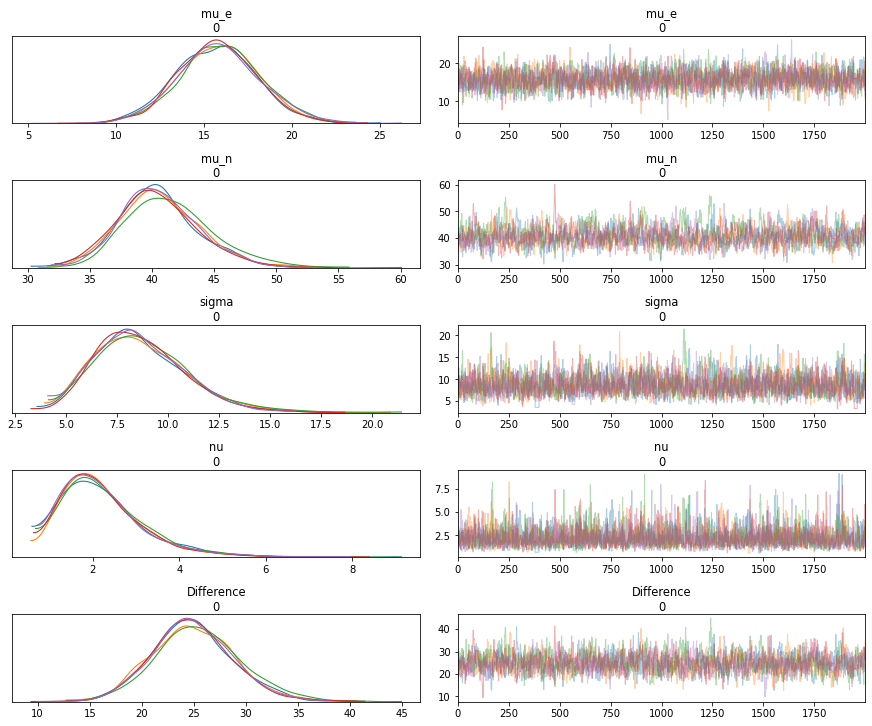

In [20]:
az.plot_trace(trace, compact=False)

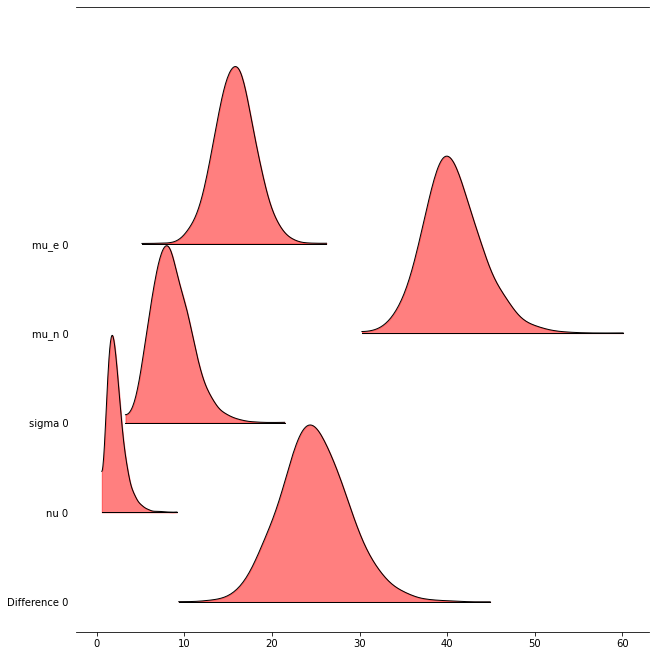

In [25]:
az.plot_forest(trace,
               kind='ridgeplot',
               colors= 'red',
               ridgeplot_alpha = 0.5,
               linewidth=1,
               combined=True,
               credible_interval = 0.95,
               ridgeplot_overlap=2.,
               figsize=(9, 9));

In [26]:
az.summary(trace, credible_interval = 0.95)

,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_e[0],15.785,2.268,11.559,20.587,0.047,0.034,2281.0,2266.0,2286.0,3486.0,1.00
mu_n[0],40.719,3.343,34.486,47.543,0.113,0.081,874.0,860.0,913.0,1323.0,1.01
sigma[0],8.622,2.255,4.586,13.058,0.058,0.041,1517.0,1501.0,1535.0,1856.0,1.00
nu[0],2.234,0.988,0.781,4.253,0.020,0.014,2367.0,2367.0,2347.0,2397.0,1.00
Difference[0],24.934,3.937,17.855,33.360,0.116,0.083,1143.0,1114.0,1165.0,1729.0,1.00


Theo phân phối hậu nghiệm, dễ dàng thấy rằng có sự khác biệt ý nghĩa về độ dày phế nang giữa 2 phân nhóm : khác biệt trung bình = 29.934 $\mu m$ với khoảng mật độ cao nhất (HDPI 95%) từ 17.855 đến 33.36 $\mu m$

Bạn vừa thực hiện thành công 1 kiểm định t- student theo trường phái Bayes